<a href="https://colab.research.google.com/github/dcpatton/keras_tuner/blob/master/keras_tuning_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import random

seed = 51
tf.random.set_seed(seed)
random.seed(seed)

print('TensorFlow version = ' + tf.__version__)

accuracies = [] # for metric tracking

TensorFlow version = 2.3.0


In [2]:
!pip install keras-tuner -q
import kerastuner as kt
print(kt.__version__)

     |████████████████████████████████| 61kB 1.9MB/s 
1.0.1


# Get the data
We will use the CIFAR10 dataset which is a classic image classification example.

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# Normalize the data
train_images, test_images = train_images / 255.0, test_images / 255.0

170500096/170498071 [==============================] - 11s 0us/step


# Baseline DNN Model

In [4]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dense(48, activation = 'relu'))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                196672    
_________________________________________________________________
dense_1 (Dense)              (None, 48)                3120      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1568      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 201,690
Trainable params: 201,690
Non-trainable params: 0
_________________________________________________________________


In [5]:
BATCH_SIZE = 128

In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

filepath='model.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True)
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

history = model.fit(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
                    validation_data=(test_images, test_labels), 
                    callbacks=[mc, es], verbose=0)

Epoch 00050: early stopping


In [7]:
model.load_weights(filepath)
metrics = model.evaluate(test_images, test_labels, verbose=0)
print('Loss = ' + str(metrics[0]))
print('Accuracy = ' + str(metrics[1]))
accuracies.append(metrics[1])

Loss = 1.9904240369796753
Accuracy = 0.4674000144004822


# Tuning the DNN thickness

What number of units should be used in each Dense layer?

In [8]:
def build_hypermodel(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
  model.add(tf.keras.layers.Dense(units=hp.Int(name='units_1', min_value=16, max_value=256, step=16), activation = 'relu'))
  model.add(tf.keras.layers.Dense(hp.Int('units_2', 16, 256, 16), activation = 'relu'))
  model.add(tf.keras.layers.Dense(hp.Int('units_3', 16, 256, 16), activation = 'relu'))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
  
  return model

In [9]:
tuner = kt.RandomSearch(hypermodel=build_hypermodel,
                        objective='val_loss',
                        max_trials=25,
                        directory='test_dir',
                        project_name='a',
                        seed=seed
                        )

tuner.search_space_summary()

In [10]:
import IPython

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [11]:
es = tf.keras.callbacks.EarlyStopping(patience=10)
tuner.search(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
             validation_data=(test_images, test_labels), 
             verbose=0, callbacks=[es, ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [12]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [13]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_1')}. The optimal number of units in the second densely-connected
layer is {best_hps.get('units_2')}. The optimal number of units in the third densely-connected
layer is {best_hps.get('units_3')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 80. The optimal number of units in the second densely-connected
layer is 224. The optimal number of units in the third densely-connected
layer is 208.



In [14]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 80)                245840    
_________________________________________________________________
dense_1 (Dense)              (None, 224)               18144     
_________________________________________________________________
dense_2 (Dense)              (None, 208)               46800     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2090      
Total params: 312,874
Trainable params: 312,874
Non-trainable params: 0
_________________________________________________________________


In [15]:
mc = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True)
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

history = model.fit(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
                    validation_data=(test_images, test_labels), 
                    callbacks=[mc, es], verbose=0)

Epoch 00059: early stopping


In [16]:
model.load_weights(filepath)
metrics = model.evaluate(test_images, test_labels, verbose=0)
print('Loss = ' + str(metrics[0]))
print('Accuracy = ' + str(metrics[1]))
accuracies.append(metrics[1])

Loss = 1.9724228382110596
Accuracy = 0.4860999882221222


Recall that the baseline model achieved the following result

```
Loss = 1.5220550298690796
Accuracy = 0.45159998536109924
```

Accurancy has improved by about 6% by tuning the thickness of the model.

# Tuning the activation functions
What activation functions should be used in each Dense layer?

In [17]:
def build_hypermodel(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
  model.add(tf.keras.layers.Dense(176, activation=hp.Choice(name='a_1', values=['relu','tanh','elu','selu','swish'])))
  model.add(tf.keras.layers.Dense(240, activation=hp.Choice(name='a_2', values=['relu','tanh','elu','selu','swish'])))
  model.add(tf.keras.layers.Dense(96, activation=hp.Choice(name='a_3', values=['relu','tanh','elu','selu','swish'])))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
  
  return model

In [18]:
tuner = kt.RandomSearch(hypermodel=build_hypermodel,
                        objective='val_loss',
                        max_trials=25,
                        directory='test_dir',
                        project_name='b',
                        seed=seed
                        )

tuner.search_space_summary()

In [19]:
es = tf.keras.callbacks.EarlyStopping(patience=10)
tuner.search(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
             validation_data=(test_images, test_labels), 
             verbose=0, callbacks=[es, ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [20]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [21]:
print(f"""
The hyperparameter search is complete. The optimal number of activation in the first densely-connected
layer is {best_hps.get('a_1')}. The optimal number of activation in the second densely-connected
layer is {best_hps.get('a_2')}. The optimal number of activation in the third densely-connected
layer is {best_hps.get('a_3')}.
""")


The hyperparameter search is complete. The optimal number of activation in the first densely-connected
layer is swish. The optimal number of activation in the second densely-connected
layer is relu. The optimal number of activation in the third densely-connected
layer is tanh.



In [22]:
model = tuner.hypermodel.build(best_hps)

In [23]:
mc = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True)
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

history = model.fit(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
                    validation_data=(test_images, test_labels), 
                    callbacks=[mc, es], verbose=0)

Epoch 00076: early stopping


In [24]:
model.load_weights(filepath)
metrics = model.evaluate(test_images, test_labels, verbose=0)
print('Loss = ' + str(metrics[0]))
print('Accuracy = ' + str(metrics[1]))
accuracies.append(metrics[1])

Loss = 1.9605963230133057
Accuracy = 0.4959000051021576


The previously tuned model (tuned units) achieved: 

```
Loss = 1.3987748622894287
Accuracy = 0.5080000162124634
```

Now we have improved accuracy a couple more percent.

# Results

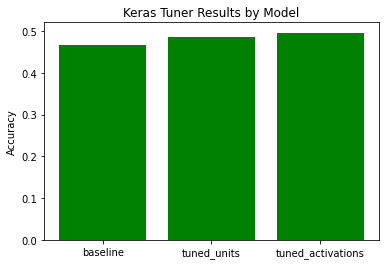

In [25]:
import matplotlib.pyplot as plt

labels = ['baseline', 'tuned_units', 'tuned_activations']

x_pos = [i for i, _ in enumerate(labels)]

plt.bar(x_pos, accuracies, color='green')
plt.ylabel("Accuracy")
plt.title("Keras Tuner Results by Model")

plt.xticks(x_pos, labels)

plt.show()